In [1]:
import string
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow import keras

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_1 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
data_2 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [ ]:
data.head(10)

In [3]:
data_1.drop('article_link', axis=1, inplace=True)
data_2.drop('article_link', axis=1, inplace=True)
data = data_1.append(data_2, ignore_index=True)

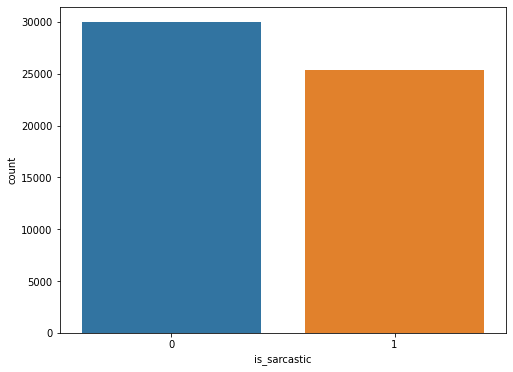

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(data.is_sarcastic)
plt.show()

In [5]:
print(data.shape)

(55328, 2)


# Preprocessing and dataset preparation

In [6]:
def preprocess(df):
    df['headline'] = df['headline'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df['headline'] = df['headline'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]+', '', x))
    return df

data_Xy = preprocess(data)

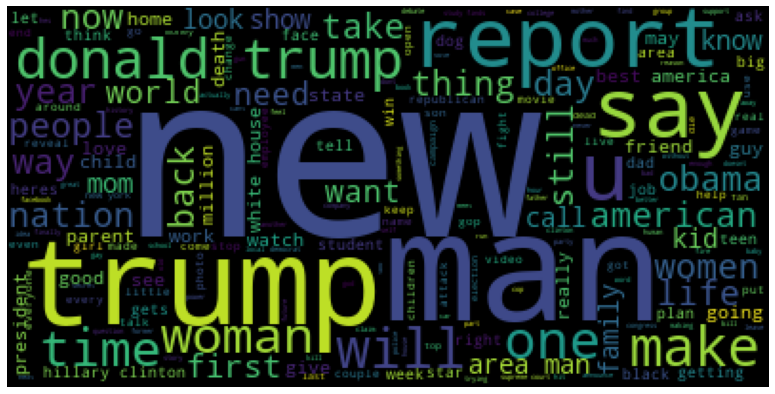

In [35]:
wordcloud2 = WordCloud().generate(' '.join(data_Xy['headline']))
# Generate plot
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [7]:
train_data = data_Xy.sample(frac=0.75, random_state=42)
test_data = data_Xy.drop(train_data.index)

BERT architecture requires specific data preparation

In [8]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(
        lambda x: InputExample(
            guid = None, # Globally unique ID for bookkeeping, unused in this case
            text_a = x[DATA_COLUMN],
            text_b = None,
            label = x[LABEL_COLUMN]
        ),
        axis = 1
    )

    validation_InputExamples = test.apply(
        lambda x: InputExample(
            guid = None,
            text_a = x[DATA_COLUMN], 
            text_b = None,
            label = x[LABEL_COLUMN]
        ),
        axis = 1
    )

    return train_InputExamples, validation_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=16):
    features = []

    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens = True,
            max_length = max_length, # truncates if len(s) > max_length
            return_token_type_ids = True,
            return_attention_mask = True,
            pad_to_max_length = True, # pads to the right by default
            truncation = True
        )

        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"],
            input_dict["token_type_ids"],
            input_dict['attention_mask']
        )

        features.append(
            InputFeatures(
                input_ids = input_ids,
                attention_mask = attention_mask,
                token_type_ids = token_type_ids,
                label = e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        output_signature = (
            {
                "input_ids": tf.TensorSpec(shape=([None]), dtype=tf.int32), 
                "attention_mask": tf.TensorSpec(shape=([None]), dtype=tf.int32),
                "token_type_ids": tf.TensorSpec(shape=([None]), dtype=tf.int32),
            },
            tf.TensorSpec(shape=(), dtype=tf.int32),
        )   
    )

# Datasets and tokenizer initialization

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
DATA_COLUMN = 'headline'
LABEL_COLUMN = 'is_sarcastic'

train_InputExamples, validation_InputExamples = convert_data_to_examples(train_data, test_data, DATA_COLUMN, LABEL_COLUMN)

train_ds = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_ds = train_ds.shuffle(10000).batch(32).repeat(2)

test_ds = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
test_ds = test_ds.batch(32)

# Model preparation and training

In [28]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_227 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
)

history = model.fit(
    train_ds,
    epochs=2,
    batch_size=32,
    validation_data=test_ds
)

Epoch 1/2
2594/2594 [==============================] - 291s 106ms/step - loss: 0.2945 - accuracy: 0.8688 - val_loss: 0.1076 - val_accuracy: 0.9662
Epoch 2/2
2594/2594 [==============================] - 276s 106ms/step - loss: 0.0411 - accuracy: 0.9863 - val_loss: 0.1082 - val_accuracy: 0.9743


The model couldn't be trained for more epochs. Because of it's size we see instant overfitting after the first epoch even with very small learning rate. Also I am considering colecting more data.